# Figure 3 from Bai et al., 2023 - GRL

This example code goes through the basic functions to make the reconstruction figures. Data needed is ocean surface vorticity, crosswind SST gradients, wind stress curl, and Coriolis parameter $f$ for normalization. The above data are stored in the format A(nt,ny,nx).

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from scipy import stats

Load stored data in the energetic region:

In [2]:
file = np.load('./w_windsstvort_3d_6257_JJA.npz')
crosswind = file['cross_sst'] # crosswind SST gradient
vort = file['vort'] # ocean surface vorticity 
curl = file['windstrcurl'] # wind stress curl

file = np.load('./w_fff_3d_6257_JJA.npz')
ff = file['fff'] # Coriolis parameter 

In [3]:
nt,ny,nx = np.shape(vort)
prnt = './'
grid = 'grid/'
xc = np.memmap(prnt+grid+'XC_'+str(nx)+'x'+str(ny),mode='r',shape=(ny,nx),
               dtype='>f4')
yc = np.memmap(prnt+grid+'YC_'+str(nx)+'x'+str(ny),mode='r',shape=(ny,nx),
               dtype='>f4')
lon = xc[0,:]
lat = yc[:,0]

In [4]:
curl[curl==0] = np.nan
crosswind[crosswind==0] = np.nan
vort[vort==0] = np.nan
vort = vort/ff # scale vorticity by f

Perform 1 day running mean of data per hour to remove some synoptic variabilities:

In [5]:
rnmean = 24
curl_1d = np.zeros((nt-rnmean,ny,nx))
vort_1d = np.zeros((nt-rnmean,ny,nx))
cross_1d = np.zeros((nt-rnmean,ny,nx))

for i in range(len(curl_1d[:,0,0])-1):
    curl_1d[i,:,:] =np.nanmean(curl[i:i+rnmean,:,:],axis=0)
    vort_1d[i,:,:] =np.nanmean(vort[i:i+rnmean,:,:],axis=0)
    cross_1d[i,:,:] =np.nanmean(crosswind[i:i+rnmean,:,:],axis=0)

Calculate $\alpha$ and $\beta$ coefficients hourly in a 2D perspective, i.e. taking into account of the dependency of current and thermal feedback:

In [6]:
coeff_1 = np.zeros((int(len(curl_1d[:,1,1])),2)) # save the coefficients 
for i in range(int(len(curl_1d[:,1,1]))):
    x = vort_1d[i,:,:].flatten()
    y = 1e4*cross_1d[i,:,:].flatten()
    z = 1e4*curl_1d[i,:,:].flatten()
    missing = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z) 
    X = np.column_stack((x[missing], y[missing]))
    model = sm.OLS(z[missing], X).fit()
    coeff_1[i,:] = model.params

Calculate $\alpha$ and $\beta$ coefficients hourly in a 1D perspective, i.e. calculating the slope of 1D binned statistics 

In [7]:
sstbinrange =  np.arange(-6.8,6.8,.2)
vortbinrange = np.arange(-6.8,6.8,.2)

x_combined = (sstbinrange[1:]+sstbinrange[:-1])*0.5
y_combined = (vortbinrange[1:]+vortbinrange[:-1])*0.5

slope_sst_ts = np.zeros((2160,1))
slope_vort_ts = np.zeros((2160,1))

for i in range(int(len(curl_1d[:,1,1]))-1):
    x = 1e4*cross_1d[i,:,:].flatten()
    y = vort_1d[i,:,:].flatten()
    z = 1e4*curl_1d[i,:,:].flatten()
    missing =  ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z) 
    onedbinned_sst,xedges,_ = stats.binned_statistic(x[missing],z[missing],statistic=np.nanmean,bins=sstbinrange)
    onedbinned_vort,yedges,_ = stats.binned_statistic(y[missing],z[missing],statistic=np.nanmean,bins=vortbinrange)
    
    missing =  ~np.isnan(x_combined) & ~np.isnan(onedbinned_sst)
    slope_sst_ts[i] = np.polyfit(x_combined[missing],onedbinned_sst[missing],1)[0]
    
    missing =  ~np.isnan(y_combined) & ~np.isnan(onedbinned_vort)
    slope_vort_ts[i] = np.polyfit(y_combined[missing],onedbinned_vort[missing],1)[0]

Calculate Person correlation coefficient squared ($r^2$) for all 4 reconstruciton: 

In [8]:
# calculate r^2 for 1-D current 
R_sq_1c = np.zeros((int(len(curl_1d[:,1,1]))-1))
for i in range(int(len(curl_1d[:,1,1]))-1):
    actual = 1e4*curl_1d[i,:,:].flatten()
    predict = slope_vort_ts[i]*vort_1d[i,:,:].flatten()
    missing =  ~np.isnan(actual) & ~np.isnan(predict)
    corr_matrix = np.corrcoef(actual[missing], predict[missing])
    corr = corr_matrix[0,1]
    R_sq_1c[i] = corr**2

# calculate r^2 for 1-D thermal 
R_sq_1t = np.zeros((int(len(curl_1d[:,1,1]))-1))
for i in range(int(len(curl_1d[:,1,1]))-1):
    actual = 1e4*curl_1d[i,:,:].flatten()
    predict = slope_sst_ts[i]*1e4*cross_1d[i,:,:].flatten()
    missing =  ~np.isnan(actual) & ~np.isnan(predict)
    corr_matrix = np.corrcoef(actual[missing], predict[missing])
    corr = corr_matrix[0,1]
    R_sq_1t[i] = corr**2
    
    
# calculate r^2 for 1-D current+thermal
R_sq_1b = np.zeros((int(len(curl_1d[:,1,1]))-1))
for i in range(int(len(curl_1d[:,1,1]))-1):
    actual = 1e4*curl_1d[i,:,:].flatten()
    predict = slope_sst_ts[i]*1e4*cross_1d[i,:,:].flatten()+slope_vort_ts[i]*vort_1d[i,:,:].flatten()
    missing =  ~np.isnan(actual) & ~np.isnan(predict)
    corr_matrix = np.corrcoef(actual[missing], predict[missing])
    corr = corr_matrix[0,1]
    R_sq_1b[i] = corr**2
    
### calculate r^2 for 2D 
R_sq_2 = np.zeros((int(len(curl_1d[:,1,1]))-1))
for i in range(int(len(curl_1d[:,1,1]))-1):
    actual = 1e4*curl_1d[i,:,:].flatten()
    predict = vort_1d[i,:,:].flatten()*coeff_1[i,0]+cross_1d[i,:,:].flatten()*1e4*coeff_1[i,1]
    missing =  ~np.isnan(actual) & ~np.isnan(predict)
    corr_matrix = np.corrcoef(actual[missing], predict[missing])
    corr = corr_matrix[0,1]
    R_sq_2[i] = corr**2

Calculate Root Mean Square Error of all four reconstructions against the simulated wind stress curl: 

In [9]:
frac_err_1c = np.zeros((int(len(curl_1d[:,1,1]))-1))
frac_err_1t = np.zeros((int(len(curl_1d[:,1,1]))-1))
frac_err_1b = np.zeros((int(len(curl_1d[:,1,1]))-1))
frac_err_2 = np.zeros((int(len(curl_1d[:,1,1]))-1))
for i in range(int(len(curl_1d[:,1,1]))-1):
    realwind = 1e4*curl_1d[i,:,:].flatten()
    wind1d = slope_vort_ts[i]*vort_1d[i,:,:].flatten()+cross_1d[i,:,:].flatten()*slope_sst_ts[i]*1e4
    wind2d = vort_1d[i,:,:].flatten()*coeff_1[i,0]+cross_1d[i,:,:].flatten()*1e4*coeff_1[i,1]
    wind1c = slope_vort_ts[i]*vort_1d[i,:,:].flatten()
    wind1t = cross_1d[i,:,:].flatten()*slope_sst_ts[i]*1e4
    frac_err_1b[i] = np.sqrt(np.nanmean(np.square(np.subtract(realwind,wind1d))))
    frac_err_1c[i] = np.sqrt(np.nanmean(np.square(np.subtract(realwind,wind1c))))
    frac_err_1t[i] = np.sqrt(np.nanmean(np.square(np.subtract(realwind,wind1t))))
    frac_err_2[i] = np.sqrt(np.nanmean(np.square(np.subtract(realwind,wind2d))))

Plotting:

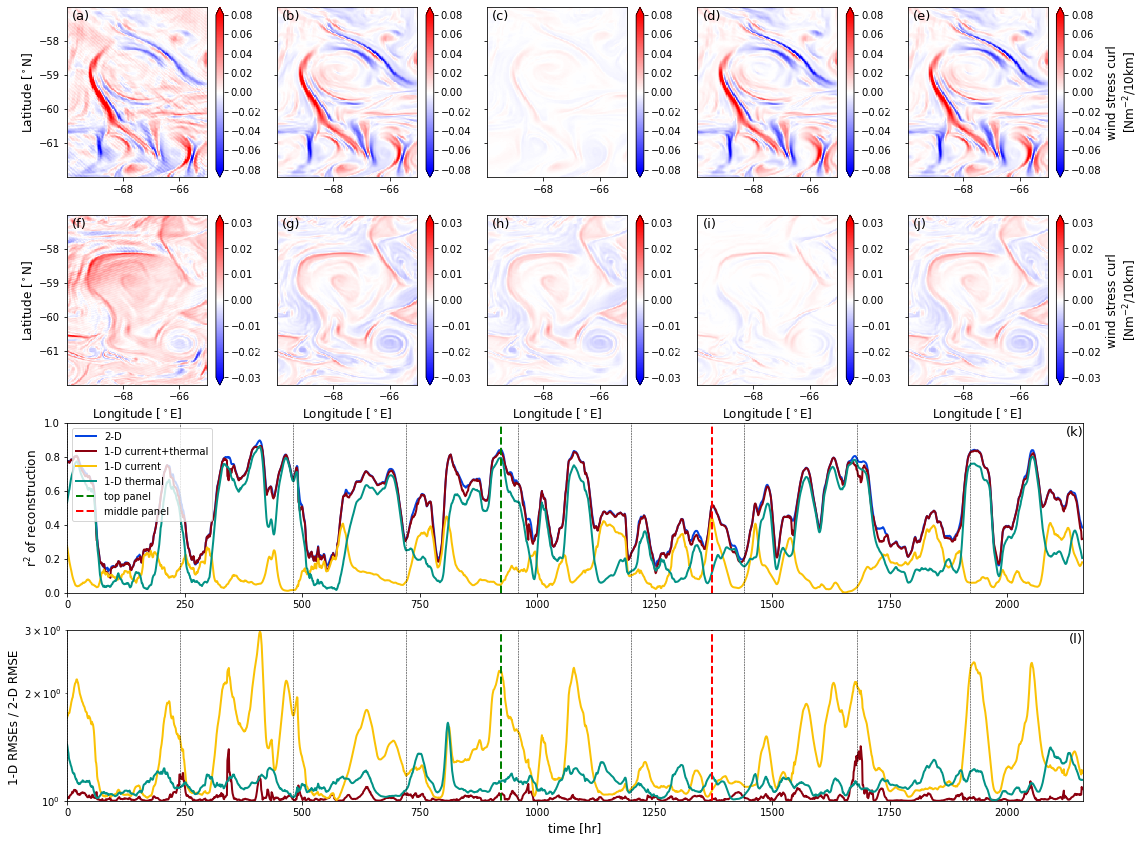

In [10]:
fig = plt.subplots(figsize=(18.2,14.6))
plt.subplots_adjust(hspace=0.22)

timestamp = 922 # this is one example of when current feedback is weak

# simulated wind stress curl
plt.subplot(451)
plt.pcolormesh(xc,yc,curl_1d[timestamp,:,:]*1e4,vmin = -0.08, vmax = 0.08,cmap='bwr')
plt.ylabel(r'Latitude [$^\circ$N]',fontsize=12)
plt.colorbar(extend='both')
plt.text(-69.8,-57.4,'(a)',fontsize=13)

# 2D reconstruction
plt.subplot(452)
plt.pcolormesh(xc,yc,vort_1d[timestamp,:,:]*coeff_1[timestamp,0]
               +cross_1d[timestamp,:,:]*1e4*coeff_1[timestamp,1],vmin = -0.08, vmax = 0.08,cmap='bwr')
plt.colorbar(extend='both')
plt.yticks(color='w')
plt.text(-69.8,-57.4,'(b)',fontsize=13)

# 1D current reconstruction
plt.subplot(453)
plt.pcolormesh(xc,yc,vort_1d[timestamp,:,:]*slope_vort_ts[timestamp],vmin = -0.08, vmax = 0.08,cmap='bwr')
plt.colorbar(extend='both')
plt.yticks(color='w')
plt.text(-69.8,-57.4,'(c)',fontsize=13)

# 1D thermal reconstruction
plt.subplot(454)
plt.pcolormesh(xc,yc,cross_1d[timestamp,:,:]*slope_sst_ts[timestamp]*1e4,vmin = -0.08, vmax = 0.08,cmap='bwr')
plt.colorbar(extend='both')
plt.yticks(color='w')
plt.text(-69.8,-57.4,'(d)',fontsize=13)

# 1D current+thermal reconsctruction
plt.subplot(455)
plt.pcolormesh(xc,yc,vort_1d[timestamp,:,:]*slope_vort_ts[timestamp]
               +cross_1d[timestamp,:,:]*slope_sst_ts[timestamp]*1e4,vmin = -0.08, vmax = 0.08,cmap='bwr')
plt.colorbar(extend='both').set_label('wind stress curl\n[Nm$^{-2}$/10km]',size=12)
plt.yticks(color='w')
plt.text(-69.8,-57.4,'(e)',fontsize=13)


# r^2 values
plt.subplot(413)
plt.plot(np.arange(0,2160),R_sq_2[:],'-',c='#0343DF',linewidth=2,label='2-D')
plt.plot(np.arange(0,2160),R_sq_1b[:],'-',c='#8C000F',linewidth=2,label='1-D current+thermal')
plt.plot(np.arange(0,2160),R_sq_1c[:],'-',c='#FAC205',linewidth=2,label='1-D current')
plt.plot(np.arange(0,2160),R_sq_1t[:],'-',c='#029386',linewidth=2,label='1-D thermal')
plt.ylabel(r'r$^2$ of reconstruction',fontsize=12)
for i in range(0,10):
    k = int(i*10)
    plt.plot([k*24, k*24],[-1, 3.2],'k--',linewidth=0.5)    
plt.plot([922,922],[0, 3.2],'g--',linewidth=2,label='top panel')
plt.plot([1371,1371],[0, 3.2],'r--',linewidth=2,label='middle panel')
plt.ylim(0,1)
plt.xlim(left=0)
plt.xlim(right=2160)
plt.legend()
plt.text(2125,0.92,'(k)',fontsize=13)

         
# RMSE ratio plotting 
plt.subplot(414)
plt.plot(np.arange(0,2160),frac_err_1b[:]/frac_err_2[:],'-',c='#8C000F',linewidth=2,label='1-D current+thermal')
plt.plot(np.arange(0,2160),frac_err_1c[:]/frac_err_2[:],'-',c='#FAC205',linewidth=2,label='1-D currrent')
plt.plot(np.arange(0,2160),frac_err_1t[:]/frac_err_2[:],'-',c='#029386',linewidth=2,label='1-D thermal')
plt.ylabel(r'1-D RMSEs / 2-D RMSE ',fontsize=12)
for i in range(0,10):
    k = int(i*10)
    plt.plot([k*24, k*24],[0, 37],'k--',linewidth=0.5)    
plt.plot([922, 922],[0, 37],'g--',linewidth=2,label='top panel')
plt.plot([1371,1371],[0, 37],'r--',linewidth=2,label='middle panel')
plt.xlabel('time [hr]',fontsize=12)
plt.ylim(1,3)
plt.yscale('log')
plt.xlim(left=0)
plt.xlim(right=2160)
plt.text(2130,2.77,'(l)',fontsize=13)


timestamp = 1371 # this is one example of when thermal feedback is weak
      
# simulated wind stress curl         
plt.subplot(456)
timestamp = 1371
plt.pcolormesh(xc,yc,curl_1d[timestamp,:,:]*1e4,vmin = -0.03, vmax = 0.03,cmap='bwr')
plt.xlabel(r'Longitude [$^\circ$E]',fontsize=12)
plt.ylabel(r'Latitude [$^\circ$N]',fontsize=12)
plt.colorbar(extend='both')
plt.text(-69.8,-57.4,'(f)',fontsize=13)

# 2D reconstruction         
plt.subplot(457)
plt.pcolormesh(xc,yc,vort_1d[timestamp,:,:]*coeff_1[timestamp,0]
               +cross_1d[timestamp,:,:]*1e4*coeff_1[timestamp,1],vmin = -0.03, vmax = 0.03,cmap='bwr')
plt.colorbar(extend='both')
plt.xlabel(r'Longitude [$^\circ$E]',fontsize=12)
plt.yticks(color='w')
plt.text(-69.8,-57.4,'(g)',fontsize=13)

         
# 1D current reconstruction
plt.subplot(458)
plt.pcolormesh(xc,yc,vort_1d[timestamp,:,:]*slope_vort_ts[timestamp],vmin = -0.03, vmax = 0.03,cmap='bwr')
plt.colorbar(extend='both')
plt.xlabel(r'Longitude [$^\circ$E]',fontsize=12)
plt.yticks(color='w')
plt.text(-69.8,-57.4,'(h)',fontsize=13)

# 1D thermal reconstruction
plt.subplot(459)
plt.pcolormesh(xc,yc,cross_1d[timestamp,:,:]*slope_sst_ts[timestamp]*1e4,vmin = -0.03, vmax = 0.03,cmap='bwr')
plt.colorbar(extend='both')
plt.xlabel(r'Longitude [$^\circ$E]',fontsize=12)
plt.yticks(color='w')
plt.text(-69.8,-57.4,'(i)',fontsize=13)

# 1D current+thermal reconstruction
plt.subplot(4,5,10)
plt.pcolormesh(xc,yc,vort_1d[timestamp,:,:]*slope_vort_ts[timestamp]
               +cross_1d[timestamp,:,:]*slope_sst_ts[timestamp]*1e4,vmin = -0.03, vmax = 0.03,cmap='bwr')
plt.colorbar(extend='both').set_label('wind stress curl\n[Nm$^{-2}$/10km]',size=12)
plt.xlabel(r'Longitude [$^\circ$E]',fontsize=12)
plt.yticks(color='w')
plt.text(-69.8,-57.4,'(j)',fontsize=13)



plt.savefig('./fig3.png',dpi=400,bbox_inches='tight') 
# plt.savefig('./fig3.pdf',dpi=400,bbox_inches='tight')